In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold

import statsmodels.tools.tools as sm
%matplotlib inline
plt.style.use('ggplot')

In [4]:
#read in data into pandas with low_memory=False
#df = pd.read_csv('/Users/morganabbitt/galvanize/capstone/NFL-Analytics//data/NFL Play by Play 2009-2018 (v5).csv', low_memory=False)

In [5]:
#important features
#play_id, game_id, home_team, away_team, posteam, posteam_type, defteam, side_of_field, yardline_100,
#game_date, game_seconds_remaining, drive, sp, qtr, down, goal_to_go, time, yrdln, ydstogo, 
#total_home_score, total_away_score, posteam_score, defteam_score, ep, epa, wp, play_type 
#third_down_converted, third_down_failed, fourth_down_converted, fourth_down_failed, penalty, touchdown
#quarter_end, field_goal_result, kick_distance

In [6]:
def clean_data(filepath):
    #read the pathname of the file in, use low_memory=False
    df = pd.read_csv(filepath, low_memory=False)
    #lst of important columns out of 255
    lst_cols = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100',
        'game_date', 'game_seconds_remaining', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 
        'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'ep', 'epa', 'wp', 'play_type', 
        'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'penalty', 'touchdown',
        'quarter_end', 'field_goal_result', 'kick_distance']
    #grabbing all important columns
    df = df[lst_cols]
    #grabbing only the 1st and third quarters to avoid time constraints and large leads
    df = df[(df['qtr'] == 1) | (df['qtr'] == 3)]
    #getting rid of plays at the end of the quarters
    df = df[df['quarter_end'] == 0]
    #gets rid of plays that are extra points or kick offs 
    df = df[df['down'].notna()]
    #returns df with all downs from quarters 1 and 3
    df['field_goal_result'] = df['field_goal_result'].replace({'missed': 0, 'made': 1, 'blocked':0}).fillna(0)
    return df
    

In [7]:
#uses clean df to grab all 4th downs
def fourth_downs(df):
    mask_4th = df['down'] == 4.0
    df = df[mask_4th].drop(df[mask_4th][df[mask_4th]['yardline_100'].isnull()].index)
    return df

In [8]:
#uses 4th down df to grab moments that were 'go for it'
def fourth_pass_or_run(df_4ths, df):
    mask_go = (df['play_type'] == 'pass') | (df['play_type'] == 'run')
    return df_4ths[mask_go]

In [9]:
dataframe = clean_data('/Users/morganabbitt/galvanize/capstone/NFL-Analytics//data/NFL Play by Play 2009-2018 (v5).csv')

In [10]:
fourths = fourth_downs(dataframe)

In [11]:
pass_or_run = fourth_pass_or_run(fourths, dataframe)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


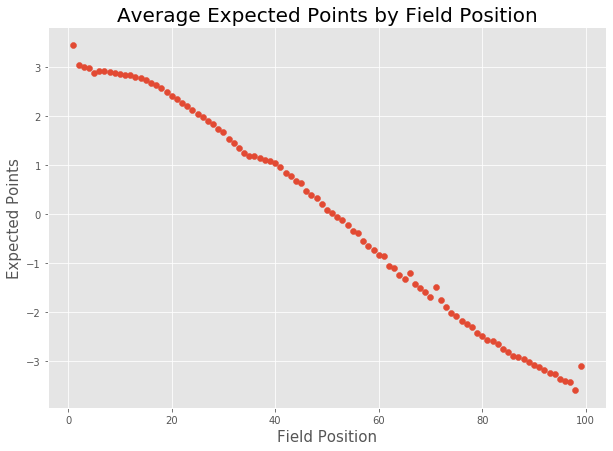

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Average Expected Points by Field Position', size=20)
plt.xlabel('Field Position', size=15)
plt.ylabel('Expected Points', size=15)
plt.scatter(fourths.groupby('yardline_100')[['ep']].mean().index, fourths.groupby('yardline_100')[['ep']].mean().values) 

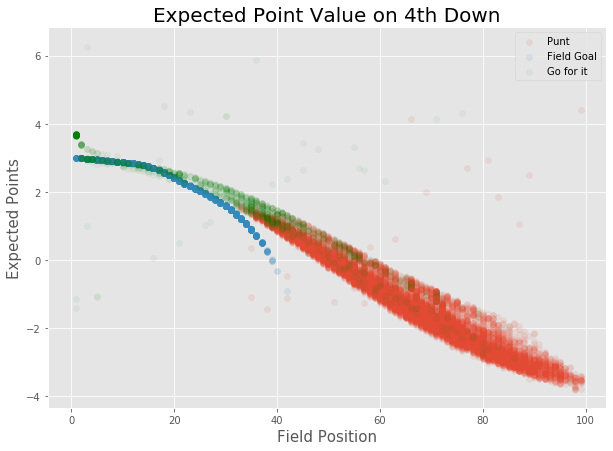

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.title('Expected Point Value on 4th Down', size=20)
plt.xlabel('Field Position', size=15)
plt.ylabel('Expected Points', size=15)
plt.scatter(fourths[fourths['play_type'] == 'punt']['yardline_100'].values, fourths[fourths['play_type'] == 'punt']['ep'].values,alpha=0.1, label='Punt')
plt.scatter(fourths[fourths['play_type'] == 'field_goal']['yardline_100'].values, fourths[fourths['play_type'] == 'field_goal']['ep'].values, alpha=0.1, label='Field Goal')
plt.scatter(pass_or_run['yardline_100'].values, pass_or_run['ep'].values, alpha=0.05, c='green', label='Go for it')
plt.legend()

In [14]:
xx = np.linspace(1,101)
best_line = x1 + x2*xx

NameError: name 'x1' is not defined

In [ ]:
#This is not as visually pleasing as the Expected Average Points by Field Position which
#is more intuitive, abandon this plot
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Expected Points by Field Position', size=20)
plt.xlabel('Field Position', size=15)
plt.ylabel('Expected Points', size=15)
plt.plot(xx, best_line, linewidth=4, color='b')
plt.scatter(fourths['yardline_100'].values, fourths['ep'].values, alpha=0.02)

In [ ]:
y = fourths['ep'].values
X = fourths['yardline_100'].values
ols = OLS(y, sm.add_constant(X))
results = ols.fit()
x1, x2 = results.params

In [ ]:
results.summary()

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Field Goal % by Field Position', size=20)
plt.xlabel('Field Position', size=15)
plt.ylabel('Percent Made', size=15)
plt.ylim(0, 1.1)
#plt.scatter(np.arange(1, 42), fourths[fourths['play_type'] == 'field_goal'].groupby('yardline_100')[['field_goal_result']].mean().values)
plt.scatter(fourths[fourths['play_type'] == 'field_goal'].groupby('yardline_100')[['field_goal_result']].mean().index, fourths[fourths['play_type'] == 'field_goal'].groupby('yardline_100')[['field_goal_result']].mean().values)
#plt.plot(xpts, yhat)

In [ ]:
y = fourths[fourths['play_type'] == 'field_goal'].groupby('yardline_100')[['field_goal_result']].mean().index
X = fourths[fourths['play_type'] == 'field_goal'].groupby('yardline_100')[['field_goal_result']].mean().values

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Net Punt Distance by Field Position', size=20)
plt.xlabel('Field Position', size=15)
plt.ylabel('Punt Distance', size=15)
plt.xlim(0, 100)
plt.scatter(np.arange(32, 100), fourths[fourths['play_type'] == 'punt'].groupby('yardline_100')[['kick_distance']].mean().values)

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Conversion % by Distance to go', size=20)
plt.xlabel('Distance to go', size=15)
plt.ylabel('Successful Conversion %', size=15)
plt.xlim(0, 25)

plt.scatter(pass_or_run[pass_or_run['yardline_100'] <= 10].groupby('ydstogo')[['fourth_down_converted']].mean().index, pass_or_run[pass_or_run['yardline_100'] <= 10].groupby('ydstogo')[['fourth_down_converted']].mean().values, label='Less than 10')
plt.scatter(pass_or_run[(pass_or_run['yardline_100'] > 10) & (pass_or_run['yardline_100'] <= 20)].groupby('ydstogo')[['fourth_down_converted']].mean().index, pass_or_run[(pass_or_run['yardline_100'] > 10) & (pass_or_run['yardline_100'] <= 20)].groupby('ydstogo')[['fourth_down_converted']].mean().values, label='Between 10 and 20')
plt.scatter(pass_or_run[pass_or_run['yardline_100'] > 20].groupby('ydstogo')[['fourth_down_converted']].mean().index, pass_or_run[pass_or_run['yardline_100'] > 20].groupby('ydstogo')[['fourth_down_converted']].mean().values, label='Greater than 20')
plt.legend()